# **Mini project: Emotion and engagement prediction from Facebook news posts**

In [4]:
import tensorflow as tf

print(tf.__version__)
print("EE enabled?", tf.executing_eagerly())

import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

2.2.0-rc2
EE enabled? True


# 1) Load news datasets from Google Drive:

In [5]:
from google.colab import drive
drive.mount('/gdrive')
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


'/device:GPU:0'



1.   Concatenate news datasets
2.   Drop rows with missing data in dataframe
3.   Drop rows with no reactions



In [0]:
import bson 
import pandas as pd

trump_data = pd.read_csv("/gdrive/My Drive/trump_filtered_data.csv") 

fox_news = pd.read_csv("/gdrive/My Drive/news_datasets/fox_news_posts.csv") 
cnn_news = pd.read_csv("/gdrive/My Drive/news_datasets/CNN_news_posts.csv") 
bbc_news = pd.read_csv("/gdrive/My Drive/news_datasets/bbc_news.csv")
nbc_news = pd.read_csv("/gdrive/My Drive/news_datasets/nbc_news.csv") 
npr_news = pd.read_csv("/gdrive/My Drive/news_datasets/npr_news.csv") 
the_los_angeles_times_news = pd.read_csv("/gdrive/My Drive/news_datasets/the_los_angeles_times_news.csv") 
cbs_news = pd.read_csv("/gdrive/My Drive/news_datasets/cbs_news.csv") 
fox_news2 = pd.read_csv("/gdrive/My Drive/news_datasets/fox_news2.csv") 
abc_news = pd.read_csv("/gdrive/My Drive/news_datasets/abc_news.csv") 


DF_list = list()
DF_list.append(fox_news)
DF_list.append(cnn_news)
DF_list.append(bbc_news)
DF_list.append(nbc_news)
DF_list.append(npr_news)
DF_list.append(the_los_angeles_times_news)
DF_list.append(cbs_news)
DF_list.append(fox_news2)
DF_list.append(abc_news)

process_list = list()

for it in DF_list:
  item = it[['message', 'post_type', 'likes_count', 'comments_count', 'shares_count', 'love_count', 'wow_count', 'haha_count', 'sad_count', 'angry_count']]
  process_list.append(item)

d = pd.concat(process_list, axis=0, sort=True)
da = d[['message', 'post_type', 'likes_count', 'comments_count', 'shares_count', 'love_count', 'wow_count', 'haha_count', 'sad_count', 'angry_count']]
dat = da.rename(columns={"message":"text", "likes_count":"likes", "comments_count":"comments", "shares_count":"shares", "love_count":"loves", "wow_count":"wows", "haha_count":"hahas", "sad_count":"sads", "angry_count":"angrys"})
dat = dat.dropna()
dat = dat[(dat['loves'] != 0) | (dat['wows'] != 0) | (dat['hahas'] != 0) | (dat['sads'] != 0) | (dat['angrys'] != 0)]

# 2) Preprocess target data: 

In [7]:
def change_news_labels(data):
  dataset = data.copy()
  likes = dataset['likes']
  comments = dataset['comments']
  shares = dataset['shares']

  loves = np.array(dataset['loves']) 
  wows = np.array(dataset['wows']) 
  hahas = np.array(dataset['hahas']) 
  sads = np.array(dataset['sads']) 
  angrys = np.array(dataset['angrys']) 

  loves_labels = []
  wows_labels = []
  hahas_labels = []
  sads_labels = []
  angrys_labels = []

  for i in range(len(np.array(dat))):
    lo = loves[i]
    wo = wows[i]
    ha = hahas[i]
    sa = sads[i]
    ang = angrys[i]

    emo_list = [lo, wo, ha, sa, ang]
    sum_count = np.sum(emo_list)
    love = (lo/sum_count)
    wow = (wo/sum_count)
    haha = (ha/sum_count)
    sad = (sa/sum_count)
    angry = (ang/sum_count)

    loves_labels.append(love)
    wows_labels.append(wow)
    hahas_labels.append(haha)
    sads_labels.append(sad)
    angrys_labels.append(angry)

  
  likes_med1 = np.percentile(likes, 33)
  likes_med2 = np.percentile(likes, 66)
  comments_med1 = np.percentile(comments, 33)
  comments_med2 = np.percentile(comments, 66)
  shares_med1 = np.percentile(shares, 33)
  shares_med2 = np.percentile(shares, 66)

  likes = ["Low" if l < likes_med1 else "Medium" if l < likes_med2 else "High" for l in likes]
  comments = ["Low" if l < comments_med1 else "Medium" if l < comments_med2 else "High" for l in comments]
  shares = ["Low" if l < shares_med1 else "Medium" if l < shares_med2 else "High" for l in shares]

  dataset['likes'] = likes
  dataset['comments'] = comments
  dataset['shares'] = shares
  dataset['loves'] =  loves_labels
  dataset['wows'] = wows_labels
  dataset['hahas'] = hahas_labels
  dataset['sads'] =  sads_labels
  dataset['angrys'] = angrys_labels
  
  return dataset

data = change_news_labels(dat)
data.drop_duplicates(subset ="text", keep = 'first', inplace = True) 
data

,text,post_type,likes,comments,shares,loves,wows,hahas,sads,angrys
0,That's ten twins in all!,link,High,Medium,High,0.343109,0.607038,0.035191,0.005865,0.008798
1,BREAKING NEWS: Fox News projects Donald J. Tru...,photo,High,High,High,0.392157,0.078431,0.058824,0.098039,0.372549
2,'A couple of months ago we weren't expected to...,video,High,High,High,0.400749,0.048689,0.064919,0.218477,0.267166
3,Do you agree with Jay Sekulow?,link,High,High,High,0.133621,0.019397,0.021552,0.112069,0.713362
4,Bill Gates said a court order requiring Apple ...,link,High,High,High,0.309589,0.063014,0.038356,0.032877,0.556164
...,...,...,...,...,...,...,...,...,...,...
14780,High turnout among Latino voters -- including ...,link,High,High,Medium,0.686976,0.019005,0.048072,0.013415,0.232532
14781,This New Jersey family went to extraordinary m...,video,Medium,High,Medium,0.197331,0.062917,0.684461,0.011439,0.043851
14783,"As Election Day arrives, one of the campaign's...",link,High,High,High,0.021544,0.057765,0.291667,0.015388,0.613636
14784,Donald J. Trump's path to victory isn't clear ...,link,Medium,High,Low,0.414179,0.010261,0.150187,0.020522,0.404851


**Heatmap of emotion correlations from Spearman matrix:**

Spearman correlation matrix: 
[[ 1.         -0.20935629  0.01915831 -0.55275802 -0.42213044]
 [-0.20935629  1.         -0.03329411 -0.07624948 -0.17362041]
 [ 0.01915831 -0.03329411  1.         -0.37301714  0.1607878 ]
 [-0.55275802 -0.07624948 -0.37301714  1.          0.21732631]
 [-0.42213044 -0.17362041  0.1607878   0.21732631  1.        ]]
 
HEATMAP:


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


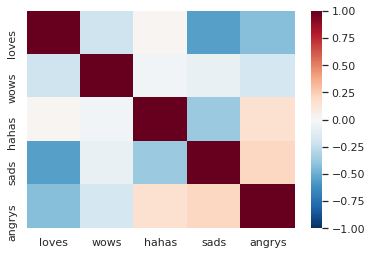

In [8]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
from scipy.stats import spearmanr

def get_spearman_correlation_heatmap(em_data):
  res = spearmanr(em_data)
  print("Spearman correlation matrix: ")
  print(res[0])
  ax = sns.heatmap(res[0], yticklabels=em_data.columns, xticklabels=em_data.columns, vmin=-1, vmax=1, cmap='RdBu_r')
  return ax

heatmap = get_spearman_correlation_heatmap(data.iloc[:, 5:10])
print(" ")
print("HEATMAP:")
heatmap

# 3) Preprocessing textual data:



1.   Remove URLs
2.   Remove numbers
3.   Remove punctuation



In [0]:
import re
import string
from sklearn.model_selection import train_test_split


def remove_urls(vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

def preprocess_data(sentence):
  URLless_string = remove_urls(sentence)
  no_number = re.sub(r'\d+', '', URLless_string)
  exclude = set(string.punctuation)
  result = ''.join(ch for ch in no_number if ch not in exclude)  
  return result

**Construct the Vocabulary and Index-Word mapping:**

In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# This class creates a word-index mapping (e.g,. "house" -> 6) and vice-versa (e.g., 6 -> "house") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  


x = [preprocess_data(s) for s in data["text"].values]
inputs = ConstructVocab(x)
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in x]

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_inp = max_length(input_tensor)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')

**Convert target data to suitable format for training:**

In [0]:
def encode_labels(arr):
  a = [[0,0,1] if e=="High" else [0,1,0] if e=="Medium" else [1,0,0] for e in arr]
  return a 


likes = np.array(data['likes'])
comments = np.array(data['comments'])
shares = np.array(data['shares'])
loves = np.array(data['loves'])
wows = np.array(data['wows'])
hahas = np.array(data['hahas'])
sads = np.array(data['sads'])
angrys = np.array(data['angrys'])

post_types = np.array(data["post_type"])

likes_target = encode_labels(likes.reshape(len(likes), 1))
comments_target = encode_labels(comments.reshape(len(comments), 1))
shares_target = encode_labels(shares.reshape(len(shares), 1))
loves_target = loves.reshape(len(loves), 1)
wows_target = wows.reshape(len(wows), 1)
hahas_target = hahas.reshape(len(hahas), 1)
sads_target = sads.reshape(len(sads), 1)
angrys_target = angrys.reshape(len(angrys), 1)


# 4) Split data

We split our data into a train and validation set. 

In [0]:
x_train, x_test, post_type_train, post_type_test, like_train, like_test, comment_train, comment_test, share_train, share_test, love_train, love_test, wow_train, wow_test, haha_train, haha_test, sad_train, sad_test, angry_train, angry_test = train_test_split(input_tensor, post_types, likes_target, comments_target, shares_target, loves_target, wows_target, hahas_target, sads_target, angrys_target, test_size=0.3, random_state=42)

y_train = np.concatenate((love_train, wow_train, haha_train, sad_train, angry_train), axis=1)
y_test = np.concatenate((love_test, wow_test, haha_test, sad_test, angry_test), axis=1)

y_eng_train = np.concatenate((comment_train, share_train, like_train), axis=1)
y_eng_test = np.concatenate((comment_test, share_test, like_test), axis=1)

post_type_tra = np.reshape(post_type_train, (post_type_train.shape[0], 1))
post_type_te = np.reshape(post_type_test, (post_type_test.shape[0], 1))
posts_train =  np.reshape(post_type_tra, (post_type_tra.shape[0], 1))
posts_test =  np.reshape(post_type_te, (post_type_te.shape[0], 1))

# 5) Emotion prediction

We load the data into a data loader, which makes it easy to manipulate the data, create batches, and apply further transformations.

In [0]:
TRAIN_BUFFER_SIZE = (x_train.shape[0])
TEST_BUFFER_SIZE = (x_test.shape[0])
BATCH_SIZE = 128
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = y_train.shape[1]
inp_shape = x_train.shape[1]

# emotion datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(TRAIN_BUFFER_SIZE) #add posts_training here for engagement prediction
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)


### Implementing a custom loss function to account for emotions correlations

In [0]:
import math

def Custom_KLD_loss(y, prediction): # add posts here

    pred = ([[0 if t<=0.2 else 1 for t in preds] for preds in (prediction)])
    ground = ([[0 if t<=0.2 else 1 for t in gr] for gr in (y)])
    li = []
    for i in range(len(pred)):
      if ((ground[i][3] == ground[i][4]) and (pred[i][3] != pred[i][4])):
        li.append(i)
      if ((ground[i][0] != ground[i][3]) and (pred[i][0] == pred[i][3])):
        li.append(i)
    
    mask_array = np.ones((128,), dtype=np.float32)
    for index in li: 
      mask_array[index] = mask_array[index]*2

    mask = tf.convert_to_tensor(mask_array)
    k = tf.keras.losses.KLD
    loss = k(y, prediction)
    return loss*mask

 
def custom_accuracy(y, yhat):
    r1 = tf.math.greater(y, 0.2)
    r2 = tf.math.greater(yhat, 0.2)
    match = tf.math.equal(r1, r2)
    n_matches = tf.reduce_sum(tf.cast(match, tf.float32))
    len_y = tf.cast(tf.size(y), tf.float32)
    acc = (n_matches/(len_y))
    return acc

### Constructing the GRU model (as a subclass of keras Model)

In [17]:
### define the GRU component
def gru(units):
  # Using CuDNNGRU(provides a 3x speedup than GRU) when it is available
  # the code automatically does that.
    if tf.test.is_gpu_available():
        print("YES: CuDNNGRU available")
        return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        print("NO: CuDNNGRU unavailable")
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_inp_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim, input_shape=(inp_shape,))
        self.gru = gru(self.hidden_units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(output_size, activation="softmax")
        
    def call(self, x, hidden):
        x = self.embedding(x) 
        output, h_state = self.gru(x, initial_state = hidden) 
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) 
        return out, h_state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

tf.keras.backend.clear_session()
GRUmodel = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
hidden = GRUmodel.initialize_hidden_state() # initialize the hidden state of the RNN

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
YES: CuDNNGRU available


In [18]:
# testing for the first batch only then break the for loop
for (batch, (inp, targ)) in enumerate(train_dataset): 
    out, state = GRUmodel(inp, hidden)
    break
GRUmodel.summary()

Model: "emo_gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  16530432  
_________________________________________________________________
cu_dnngru (CuDNNGRU)         multiple                  3938304   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5125      
Total params: 20,473,861
Trainable params: 20,473,861
Non-trainable params: 0
_________________________________________________________________


### GRU training

In [60]:
optimizer = tf.keras.optimizers.Adam()
EPOCHS = 3

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = GRUmodel.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset): # add posts here 
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = GRUmodel(inp, hidden)
            emo_loss = Custom_KLD_loss(targ, predictions) #add posts here
            loss += emo_loss
            
        batch_loss = (loss / int(targ.shape[1])) 
        total_loss += batch_loss
        
        batch_accuracy = custom_accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, GRUmodel.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=(zip(gradients, GRUmodel.trainable_variables)))

        if batch % 50 == 0:
            print('Epoch {} Batch {} '.format(epoch + 1,batch))
            
    ### Validating
    hidden = GRUmodel.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(test_dataset):        
        predictions,_ = GRUmodel(inp, hidden)        
        batch_accuracy = custom_accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / TEST_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 
Epoch 1 Batch 50 
Epoch 1 Batch 100 
Epoch 1 Batch 150 
Epoch 1 Batch 200 
Epoch 1 Batch 250 
Epoch 1 Batch 300 
Epoch 1 Batch 350 
Epoch 1 Batch 400 
Epoch 1 -- Train Acc. 0.7844 -- Val Acc. 0.7353
Time taken for 1 epoch 296.8420355319977 sec

Epoch 2 Batch 0 
Epoch 2 Batch 50 
Epoch 2 Batch 100 
Epoch 2 Batch 150 
Epoch 2 Batch 200 
Epoch 2 Batch 250 
Epoch 2 Batch 300 
Epoch 2 Batch 350 
Epoch 2 Batch 400 
Epoch 2 -- Train Acc. 0.8297 -- Val Acc. 0.7427
Time taken for 1 epoch 296.3518843650818 sec

Epoch 3 Batch 0 
Epoch 3 Batch 50 
Epoch 3 Batch 100 
Epoch 3 Batch 150 
Epoch 3 Batch 200 
Epoch 3 Batch 250 
Epoch 3 Batch 300 
Epoch 3 Batch 350 
Epoch 3 Batch 400 
Epoch 3 -- Train Acc. 0.8676 -- Val Acc. 0.7432
Time taken for 1 epoch 296.2948338985443 sec



### Constructing the LSTM model (as a subclass of keras Model)

In [19]:
### define the LSTM component
def lstm(units):
    if tf.test.is_gpu_available():
        print("YES: CuDNNLSTM available")
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        print("NO: CuDNNLSTM unavailable")
        return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoLSTM(tf.keras.Model):
    def __init__(self, vocab_inp_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoLSTM, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim, input_shape=(inp_shape,))
        self.lstm = lstm(self.hidden_units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(output_size, activation="softmax")
        
    def call(self, x, hidden):
        x = self.embedding(x) 
        output, h_state, state = self.lstm(x, initial_state = [hidden, hidden]) 
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) 
        return out, h_state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

tf.keras.backend.clear_session()
LSTMmodel = EmoLSTM(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
hidden = LSTMmodel.initialize_hidden_state() # initialize the hidden state of the RNN

YES: CuDNNLSTM available


### LSTM training:

In [21]:
opt = tf.keras.optimizers.Adam()

EPOCHS = 4

for epoch in range(EPOCHS):
    start = time.time()
    
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            # predictions = tf.convert_to_tensor(LSTMmodel.predict(inp, batch_size=BATCH_SIZE))
            predictions,_ = LSTMmodel(inp, hidden)
            emo_loss = Custom_KLD_loss(targ, predictions)
            loss += emo_loss
      
        batch_loss = (loss / int(targ.shape[1])) 
        total_loss += batch_loss

        batch_accuracy = custom_accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        gradients = tape.gradient(loss, LSTMmodel.trainable_variables)
        opt.apply_gradients(zip(gradients, LSTMmodel.trainable_variables))

        if batch % 50 == 0:
            print('Epoch {} Batch {} '.format(epoch + 1,batch))           

    for (batch, (inp, targ)) in enumerate(test_dataset):        
        predictions,_ = LSTMmodel(inp, hidden)        
        batch_accuracy = custom_accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / TEST_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 
Epoch 1 Batch 50 
Epoch 1 Batch 100 
Epoch 1 Batch 150 
Epoch 1 Batch 200 
Epoch 1 Batch 250 
Epoch 1 Batch 300 
Epoch 1 Batch 350 
Epoch 1 Batch 400 
Epoch 1 -- Train Acc. 0.6210 -- Val Acc. 0.6062
Time taken for 1 epoch 391.4581491947174 sec

Epoch 2 Batch 0 
Epoch 2 Batch 50 
Epoch 2 Batch 100 
Epoch 2 Batch 150 
Epoch 2 Batch 200 
Epoch 2 Batch 250 
Epoch 2 Batch 300 
Epoch 2 Batch 350 
Epoch 2 Batch 400 
Epoch 2 -- Train Acc. 0.6560 -- Val Acc. 0.6953
Time taken for 1 epoch 396.314414024353 sec

Epoch 3 Batch 0 
Epoch 3 Batch 50 
Epoch 3 Batch 100 
Epoch 3 Batch 150 
Epoch 3 Batch 200 
Epoch 3 Batch 250 
Epoch 3 Batch 300 
Epoch 3 Batch 350 
Epoch 3 Batch 400 
Epoch 3 -- Train Acc. 0.7353 -- Val Acc. 0.7234
Time taken for 1 epoch 401.0300145149231 sec

Epoch 4 Batch 0 
Epoch 4 Batch 50 
Epoch 4 Batch 100 
Epoch 4 Batch 150 
Epoch 4 Batch 200 
Epoch 4 Batch 250 
Epoch 4 Batch 300 
Epoch 4 Batch 350 
Epoch 4 Batch 400 
Epoch 4 -- Train Acc. 0.7910 -- Val Acc. 0.7355

### CNN training (Sequential Keras Model)

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_inp_size, 64, input_length=inp_shape))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(target_size, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.KLD,
              metrics=[custom_accuracy])
history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=256,
                    validation_data=(x_test, y_test),
                    verbose=1)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 69, 64)            4132608   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 67, 64)            12352     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4288)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4288)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                214450    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255       
Total params: 4,359,665
Trainable params: 4,359,665
Non-trainable params: 0
____________________________________________

# 5) Analysis of Polarity and Controversy from an emotion distribution

In [38]:
from scipy.spatial import distance

def compute_controversy(prediction):
  uniform_distribution = [0.2, 0.2, 0.2, 0.2, 0.2]
  return (1 - distance.jensenshannon(prediction, uniform_distribution, 2.0))
  
# examples
res1 = compute_controversy([0.2, 0.2, 0.2, 0.2, 0.2])
res2 = compute_controversy([1, 0, 0, 0, 0])
print("Controversy from a uniform distribution: ", res1)
print("Controversy from an imbalanced distribution:", res2)

Controversy from a uniform distribution:  1.0
Controversy from an imbalanced distribution: 0.21898364485051436


(22861, 69)

In [0]:
def compute_polarity(prediction):
  return ((prediction[0]+prediction[1]+prediction[2])/(prediction[0]+prediction[1]+prediction[2]+prediction[3]+prediction[4]))

polarity_example = compute_polarity([0.2, 0.1, 0.1, 0.3, 0.3])

##--------------------------------------------------------------------------------------------------------------------------------------------------------------





# 5) Engagement prediction

### Preparing the engagement datasets

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_eng_train, posts_train)).shuffle(TRAIN_BUFFER_SIZE) #add posts_training here for engagement prediction
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_eng_test, posts_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

output_size = y_eng_train.shape[1]

### Custom loss function for engagement training

In [0]:
def custom_engagement_loss(y, yhat, posts_train):
  binary_pred = tf.math.greater(yhat, 0.5)
  batch_size = tf.cast(tf.shape(y)[0], dtype=tf.int32) 
  loss = tf.keras.losses.binary_crossentropy(y, yhat)
  li = []

  for i in range(batch_size):
    loss_factor = 1
    if (posts_train[i]=="video" or posts_train[i]=="photo"):
      ground_sample = tf.cast(y[i], tf.int32)
      pred_sample = tf.cast(binary_pred[i], tf.int32)
      
      if (ground_sample[2]==1 and pred_sample[0]==1):
        loss_factor = loss_factor+1
      if (ground_sample[5]==1 and pred_sample[3]==1):
        loss_factor = loss_factor+1
      if (ground_sample[8]==1 and pred_sample[6]==1):
        loss_factor = loss_factor+1
    
    li.append(loss_factor)

  ma = tf.convert_to_tensor(li)
  mask = tf.cast(ma, dtype=tf.float32)
  return loss*mask

def eng_accuracy(y, yhat):
  bin_yhat = tf.math.greater(yhat, 0.5)
  match = tf.math.equal(tf.cast(y, tf.int64), tf.cast(bin_yhat, tf.int64))
  n_matches = tf.reduce_sum(tf.cast(match, tf.float32))
  len_y = tf.cast(tf.size(y), tf.float32)
  acc = (n_matches/(len_y))
  return acc

### Constructing the engagement GRU model 

In [98]:
### define the GRU component
def gru(units):
  # Using CuDNNGRU(provides a 3x speedup than GRU) when it is available
  # the code automatically does that.
    if tf.test.is_gpu_available():
        print("YES: CuDNNGRU available")
        return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        print("NO: CuDNNGRU unavailable")
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_inp_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim, input_shape=(inp_shape,))
        self.gru = gru(self.hidden_units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(output_size, activation="sigmoid")
        
    def call(self, x, hidden):
        x = self.embedding(x) 
        output, h_state = self.gru(x, initial_state = hidden) 
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) 
        return out, h_state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

tf.keras.backend.clear_session()
GRUmodel = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, output_size)
hidden = GRUmodel.initialize_hidden_state() # initialize the hidden state of the RNN

YES: CuDNNGRU available


### GRU training

In [99]:
optimizer = tf.keras.optimizers.Adam()
EPOCHS = 4

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = GRUmodel.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, post_type)) in enumerate(train_dataset): # add posts here 
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = GRUmodel(inp, hidden)
            engagement_loss = custom_engagement_loss(targ, predictions, post_type) #add posts here
            loss += engagement_loss
            
        batch_loss = (loss / int(targ.shape[1])) 
        total_loss += batch_loss
        
        batch_accuracy = eng_accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, GRUmodel.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=(zip(gradients, GRUmodel.trainable_variables)))

        if batch % 50 == 0:
            print('Epoch {} Batch {} '.format(epoch + 1,batch))
            
    ### Validating
    hidden = GRUmodel.initialize_hidden_state()

    for (batch, (inp, targ, post_type)) in enumerate(test_dataset):        
        predictions,_ = GRUmodel(inp, hidden)        
        batch_accuracy = eng_accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / TEST_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 
Epoch 1 Batch 50 
Epoch 1 Batch 100 
Epoch 1 Batch 150 
Epoch 1 Batch 200 
Epoch 1 Batch 250 
Epoch 1 Batch 300 
Epoch 1 Batch 350 
Epoch 1 Batch 400 
Epoch 1 -- Train Acc. 0.6702 -- Val Acc. 0.6837
Time taken for 1 epoch 146.8789746761322 sec

Epoch 2 Batch 0 
Epoch 2 Batch 50 
Epoch 2 Batch 100 
Epoch 2 Batch 150 
Epoch 2 Batch 200 
Epoch 2 Batch 250 
Epoch 2 Batch 300 
Epoch 2 Batch 350 
Epoch 2 Batch 400 
Epoch 2 -- Train Acc. 0.7028 -- Val Acc. 0.6942
Time taken for 1 epoch 146.95168161392212 sec

Epoch 3 Batch 0 
Epoch 3 Batch 50 
Epoch 3 Batch 100 
Epoch 3 Batch 150 
Epoch 3 Batch 200 
Epoch 3 Batch 250 
Epoch 3 Batch 300 
Epoch 3 Batch 350 
Epoch 3 Batch 400 
Epoch 3 -- Train Acc. 0.7452 -- Val Acc. 0.6848
Time taken for 1 epoch 146.21924495697021 sec

Epoch 4 Batch 0 
Epoch 4 Batch 50 
Epoch 4 Batch 100 
Epoch 4 Batch 150 
Epoch 4 Batch 200 
Epoch 4 Batch 250 
Epoch 4 Batch 300 
Epoch 4 Batch 350 
Epoch 4 Batch 400 
Epoch 4 -- Train Acc. 0.7896 -- Val Acc. 0.6

### Constructing LSTM engagement model

In [24]:
### define the LSTM component
def lstm(units):
    if tf.test.is_gpu_available():
        print("YES: CuDNNLSTM available")
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        print("NO: CuDNNLSTM unavailable")
        return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoLSTM(tf.keras.Model):
    def __init__(self, vocab_inp_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoLSTM, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim, input_shape=(inp_shape,))
        self.lstm = lstm(self.hidden_units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(output_size, activation="sigmoid")
        
    def call(self, x, hidden):
        x = self.embedding(x) 
        output, h_state, state = self.lstm(x, initial_state = [hidden, hidden]) 
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) 
        return out, h_state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

tf.keras.backend.clear_session()
LSTMmodel = EmoLSTM(vocab_inp_size, embedding_dim, units, BATCH_SIZE, output_size)
hidden = LSTMmodel.initialize_hidden_state() # initialize the hidden state of the RNN

YES: CuDNNLSTM available


### LSTM training:

In [26]:
opt = tf.keras.optimizers.Adam()

EPOCHS = 4

for epoch in range(EPOCHS):
    start = time.time()
    
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, posts_type)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            # predictions = tf.convert_to_tensor(LSTMmodel.predict(inp, batch_size=BATCH_SIZE))
            predictions,_ = LSTMmodel(inp, hidden)
            emo_loss = custom_engagement_loss(targ, predictions, posts_type)
            loss += emo_loss
      
        batch_loss = (loss / int(targ.shape[1])) 
        total_loss += batch_loss

        batch_accuracy = eng_accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        gradients = tape.gradient(loss, LSTMmodel.trainable_variables)
        opt.apply_gradients(zip(gradients, LSTMmodel.trainable_variables))

        if batch % 50 == 0:
            print('Epoch {} Batch {} '.format(epoch + 1,batch))           

    for (batch, (inp, targ, posts_type)) in enumerate(test_dataset):        
        predictions,_ = LSTMmodel(inp, hidden)        
        batch_accuracy = eng_accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / TEST_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 
Epoch 1 Batch 50 
Epoch 1 Batch 100 
Epoch 1 Batch 150 
Epoch 1 Batch 200 
Epoch 1 Batch 250 
Epoch 1 Batch 300 
Epoch 1 Batch 350 
Epoch 1 Batch 400 
Epoch 1 -- Train Acc. 0.6666 -- Val Acc. 0.6667
Time taken for 1 epoch 185.63288617134094 sec

Epoch 2 Batch 0 
Epoch 2 Batch 50 
Epoch 2 Batch 100 
Epoch 2 Batch 150 
Epoch 2 Batch 200 
Epoch 2 Batch 250 
Epoch 2 Batch 300 
Epoch 2 Batch 350 
Epoch 2 Batch 400 
Epoch 2 -- Train Acc. 0.6642 -- Val Acc. 0.6667
Time taken for 1 epoch 188.60984063148499 sec

Epoch 3 Batch 0 
Epoch 3 Batch 50 
Epoch 3 Batch 100 
Epoch 3 Batch 150 
Epoch 3 Batch 200 
Epoch 3 Batch 250 
Epoch 3 Batch 300 
Epoch 3 Batch 350 
Epoch 3 Batch 400 
Epoch 3 -- Train Acc. 0.6678 -- Val Acc. 0.6713
Time taken for 1 epoch 187.5673303604126 sec

Epoch 4 Batch 0 
Epoch 4 Batch 50 
Epoch 4 Batch 100 
Epoch 4 Batch 150 
Epoch 4 Batch 200 
Epoch 4 Batch 250 
Epoch 4 Batch 300 
Epoch 4 Batch 350 
Epoch 4 Batch 400 
Epoch 4 -- Train Acc. 0.6906 -- Val Acc. 0.6

### CNN engagement model

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_inp_size, 64, input_length=inp_shape))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(output_size, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[eng_accuracy])
history = model.fit(x_train,
                    y_eng_train,
                    epochs=4,
                    batch_size=256,
                    validation_data=(x_test, y_eng_test),
                    verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 69, 64)            4132608   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 67, 64)            12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 4288)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4288)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                214450    
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 459       
Total params: 4,359,869
Trainable params: 4,359,869
Non-trainable params: 0
____________________________________________